In [1]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mgimg
import scipy as sp
import numpy as np
from scipy import interpolate
from scipy.interpolate import interp1d
from IPython.display import display
%matplotlib inline
#%config InlineBackend.close_figures = False
from scipy.io.idl import readsav


In [2]:
rawfilt = np.loadtxt("2MASS-2MASS.J.dat",unpack="True",skiprows=0)
# load spex spectrum and skip to 1um
rawspec = np.loadtxt("spex_prism_0355+1133_091207--L5.txt",unpack="True",skiprows=1)
rawvega = np.loadtxt("vega.txt", unpack="True", skiprows=6)
print rawfilt.shape
rawfilt[0,:] = rawfilt[0,:] / 10000.
rawvega[0,:] = rawvega[0,:] / 10000.
rawvega[1,:] = rawvega[1,:] * 10. # erg/cm/s/A to W/m2/um

(2, 107)


In [3]:
# Now trim target spectrum to wavelength region of filter, and rebin filter onto new target grid
w1 = rawfilt[0,0]
w2 = rawfilt[0,rawfilt.shape[1] -1]
trimspec =  rawspec[:,np.logical_not(np.logical_or(rawspec[0,:] > w2, rawspec[0,:] < w1))]
wfit = sp.interpolate.splrep(rawfilt[0,:],rawfilt[1,:],s=0)
filt = np.zeros_like(trimspec)
filt[0,:] = trimspec[0,:]
# should we multiply filter by lambda and renormalise to get response curve in terms of flux, instead of photons???
wfilt = sp.interpolate.splev(filt[0,:],wfit,der=0)# * filt[0,:]
filt[1,:] = wfilt
#filt[1,:] = wfilt / np.amax(wfilt)
# and vega
trimvega =  rawvega[:,np.logical_not(np.logical_or(rawvega[0,:] > w2, rawvega[0,:] < w1))]
wfit = sp.interpolate.splrep(trimvega[0,:],trimvega[1,:],s=0)
vega = np.zeros_like(trimspec)
vega[0,:] = filt[0,:]
vega[1,:] = sp.interpolate.splev(filt[0,:],wfit,der=0)

In [4]:
Mag = 14.05
intspec = sum(filt[1,:]*trimspec[1,:])
intvega = sum(filt[1,:]*vega[1,:])
scale =(10.**(-Mag/2.5)) * (intvega / intspec)
print scale
intspec = 0.
intvega = 0.
print filt.shape
sbin = np.zeros(filt.shape[1])
for i in range(1,filt.shape[1]-1):
    sbin[i]= ((trimspec[0,i] - trimspec[0,i-1]) + (trimspec[0,i+1] - trimspec[0,i])) / 2.
# Deal with the ends...
sbin[0] = sbin[1]
sbin[sbin.size-1] = sbin[sbin.size-2]
intspec = sum(sbin*filt[1,:]*trimspec[1,:])
intvega = sum(sbin*filt[1,:]*vega[1,:])
scale =(10.**(-Mag/2.5)) * (intvega / intspec)
print scale

1.30087491539e-14
(3, 91)
1.29643073272e-14


In [5]:
#scale = 9.95766136255e-15
scalespec = np.empty_like(rawspec)
scalespec[0,:] = rawspec[0,:]
scalespec[1,:] = rawspec[1,:] * scale
scalespec[2,:] = rawspec[2,:] * scale

In [6]:
np.savetxt('2M0355_2massJcalib_full.dat', np.c_[scalespec[0],scalespec[1],scalespec[2]])

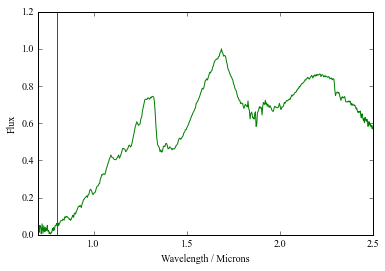

In [7]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.7, 2.5,0.0,1.2])


plt.plot(rawspec[0,:],rawspec[1,:],'g-')
plt.plot([0.8,0.8],[0.,3.0],'r-')
plt.plot([2.5,2.5],[0.,3.0],'r-')

plt.ylabel(r'Flux')
plt.xlabel('Wavelength / Microns')


In [8]:
disp = np.zeros([rawspec.shape[1] - 1])
print disp.shape

(561,)


In [9]:
for i in range (0,rawspec.shape[1]-1):
    disp[i] = rawspec[0,i+1] - rawspec[0,i]
    
wlen = rawspec.shape[1]
dlen = wlen - 1
print wlen
print dlen

562
561


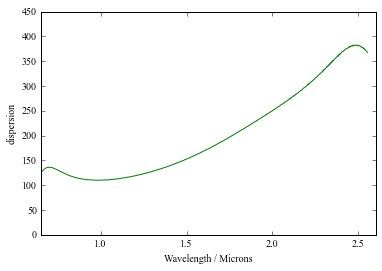

In [10]:
plt.rc('font',family='Times New Roman')
fig=plt.figure(dpi=320)
plt.axis([0.65,2.6,0.0,450])


plt.plot(rawspec[0,0:dlen],(rawspec[0,0:dlen]/disp)/2.355,'g-')

plt.ylabel(r'dispersion')
plt.xlabel('Wavelength / Microns')

In [41]:
c1 = np.array((np.where(scalespec[0] < 1.8)))[0,::3]
#c1 =  tmp[0,::3]
print c1
tmp = np.array((np.where(scalespec[0] > 2.0)))
c2 =  tmp[0,::3]
print c2
np.sum(scalespec[1,tmp])

[  0   3   6   9  12  15  18  21  24  27  30  33  36  39  42  45  48  51
  54  57  60  63  66  69  72  75  78  81  84  87  90  93  96  99 102 105
 108 111 114 117 120 123 126 129 132 135 138 141 144 147 150 153 156 159
 162 165 168 171 174 177 180 183 186 189 192 195 198 201 204 207 210 213
 216 219 222 225 228 231 234 237 240 243 246 249 252 255 258 261 264 267
 270 273 276 279 282 285 288 291 294 297 300 303 306 309 312 315 318]
[376 379 382 385 388 391 394 397 400 403 406 409 412 415 418 421 424 427
 430 433 436 439 442 445 448 451 454 457 460 463 466 469 472 475 478 481
 484 487 490 493 496 499 502 505 508 511 514 517 520 523 526 529 532 535
 538 541 544 547 550 553 556 559]


1.7575552501062512e-12